# **Statistical Tests**

## Objectives

* Perform distribution checks on the data
* Test project hypotheses through statistical tests

## Inputs

* Cleaned data from ETL pipeline

## Outputs

* Histograms, Bar Charts and Scatter Plots



---

# Import Data and Load Packages

Load packages required to run the notebook -

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
import statsmodels.formula.api as smf
sns.set_style('whitegrid')

Import cleaned data produced by the ETL pipeline.

In [5]:
# *Import raw data for testing
# Import cleaned data from ETL pipeline into dataframe

df = pd.read_csv("../data/insurance-cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1337 non-null   int64  
 1   sex           1337 non-null   object 
 2   bmi           1337 non-null   float64
 3   children      1337 non-null   int64  
 4   smoker        1337 non-null   int64  
 5   region        1337 non-null   int64  
 6   charges       1337 non-null   float64
 7   bmi_category  1337 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 83.7+ KB


Convert data types for categorical variables so that they are handled correctly in the code.

In [6]:
# remap smoker status as yes or no
df['smoker'] = df['smoker'].map(lambda x: 'yes' if x == 1 else 'no')

# convert region values from number to string
# create a dictionary to map region values to name
reg_map = {0:'North East', 1:'North West', 2:'South East', 3:'South West' }

# create column with region names from region number using reg_map
df['region'] = df['region'].map(reg_map)
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,yes,South West,16884.92400,Overweight
1,18,male,33.770,1,no,South East,1725.55230,Obese
2,28,male,33.000,3,no,South East,4449.46200,Obese
3,33,male,22.705,0,no,North West,21984.47061,Normal
4,32,male,28.880,0,no,North West,3866.85520,Overweight


---

# Initial Visualisations and Distribution Checks - Bar Charts

* In this section we will create a series of Bar Charts for initial visualisation of the data, and to review how it's distributed.

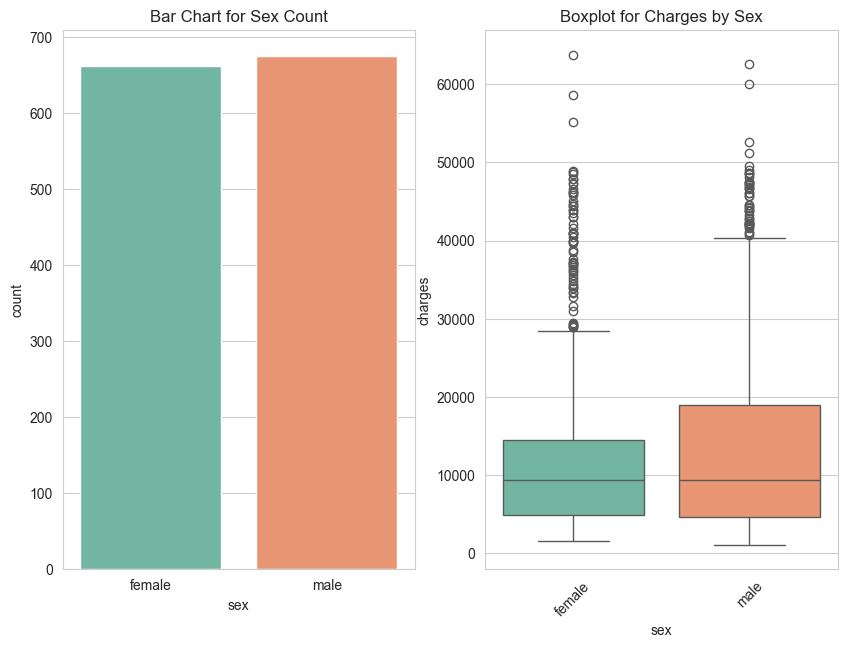

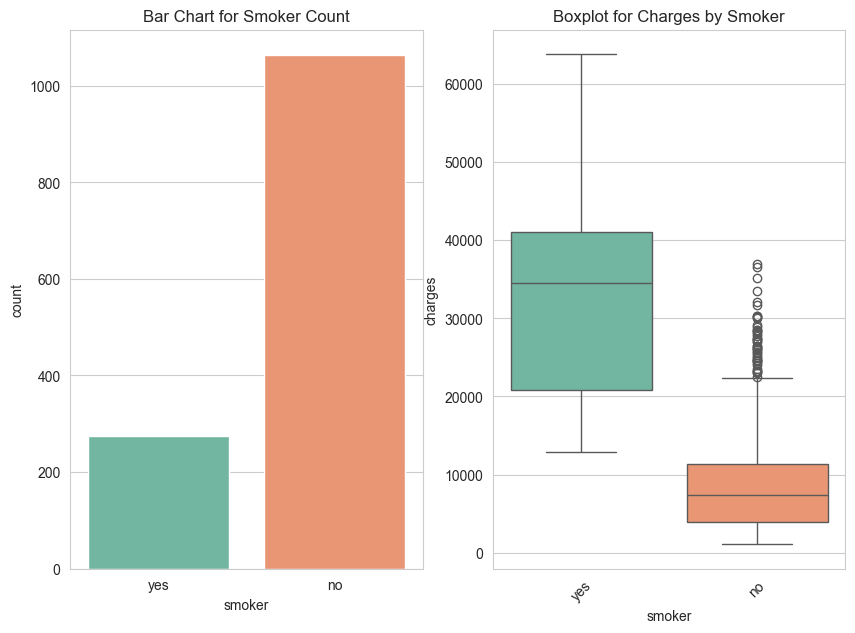

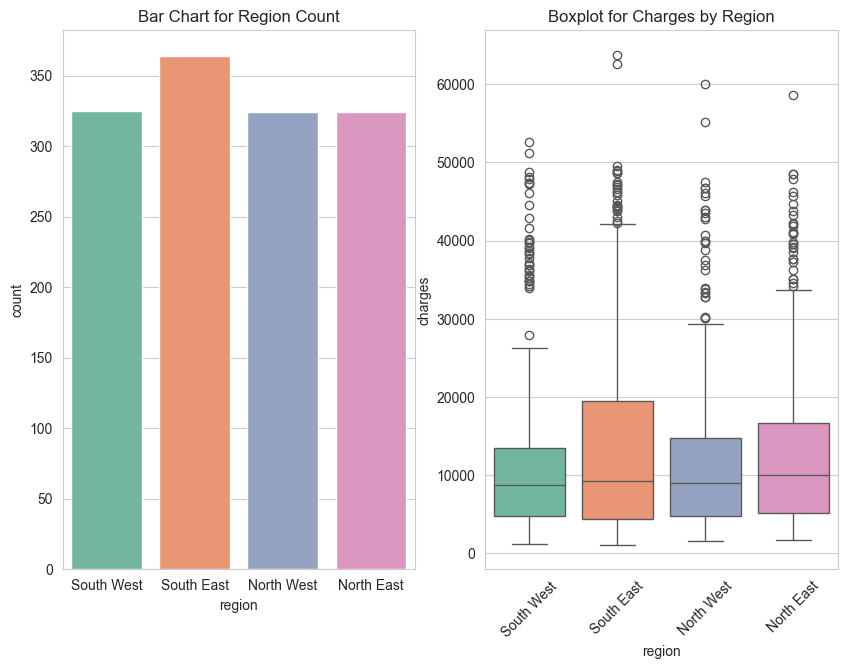

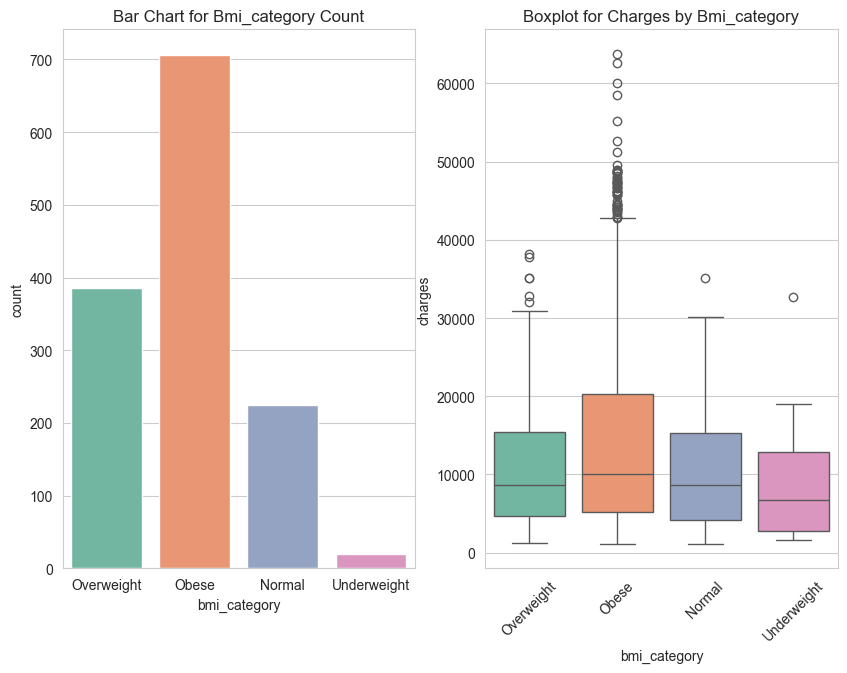

In [7]:
# create a dataframe of categorical columns
df_cat = df.select_dtypes(include='object')

# Loop through each categorical column and create plots
for col in df_cat:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,7))
    counts = df_cat[col].value_counts()
    
    # ---- Bar chart ----
    sns.countplot(x=col, data=df_cat, ax=axs[0], hue=col, palette="Set2")
    axs[0].title.set_text(f"Bar Chart for {col.capitalize()} Count")
    plt.xticks(rotation=45)

    # ---- Boxplot ----
    sns.boxplot(x=col, y='charges', data=df, ax=axs[1], hue=col, palette="Set2")
    axs[1].title.set_text(f"Boxplot for Charges by {col.capitalize()}")
    plt.show()

* From these charts we can see that the split of data across different regions and by sex is roughly equal.<br>
* BMI category and smoker status are less balanced and we may not be able to accurately predict charges for underrepresented groups in these categories.

# Initial Visualisations and Distribution Checks - Histograms

* In this section we will use a series of Histograms for the same purpose.

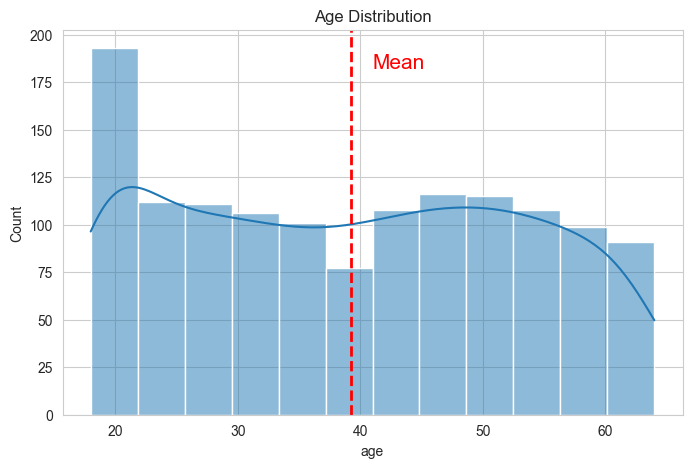

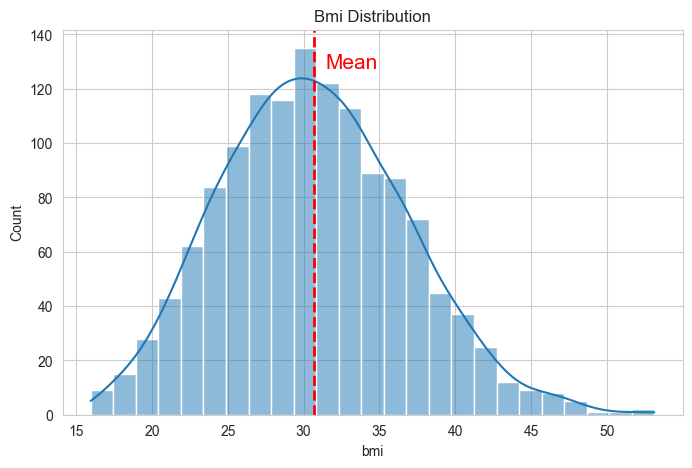

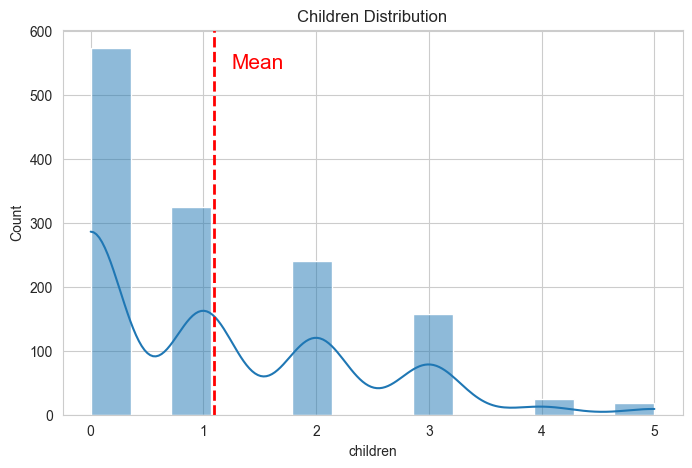

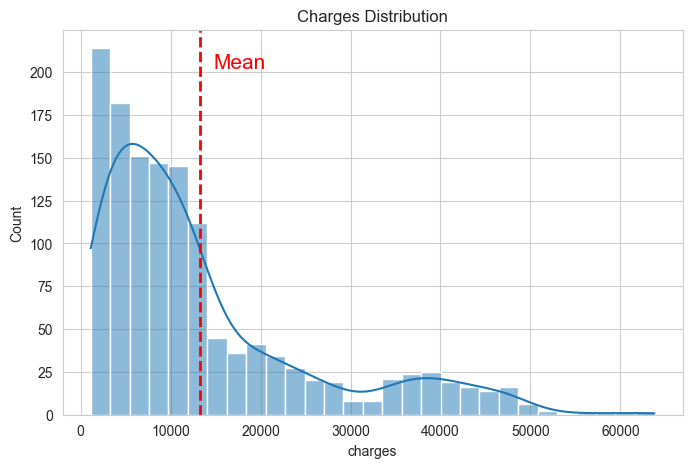

In [8]:
# create a dataframe of only numeric columns
df_num = df.select_dtypes(include=[np.number])

# loop through numeric columns and create a distribution chart for each
for col in df_num.columns:
  fig, axes = plt.subplots(figsize=(8,5))
  plt.title(f"{col.capitalize()} Distribution")
  sns.histplot(data=df_num, x=col, kde=True)
  plt.axvline(df_num[col].mean(), color='r', linestyle='dashed', linewidth=2)
  plt.text(x=df_num[col].mean() + df_num[col].std()/8 , y=axes.get_ylim()[1] * 0.90, s='Mean', fontsize=15, c='r') # offset mean label
  plt.show()
  print("\n")


Age appears to have a fairly uniform distribution in this dataset.<br>
BMI looks normally distributed<br>
Number of children and Insurance charges are both positively skewed

In [9]:
# check skewness of columns

df_num.skew()

age         0.054781
bmi         0.283914
children    0.937421
charges     1.515391
dtype: float64

In [10]:
# check data for normality

pg.normality(data=df, alpha=0.05)

,W,pval,normal
age,0.944856,6.210453e-22,False
bmi,0.993876,2.575293e-05,False
children,0.823397,5.404484e-36,False
charges,0.814761,1.195974e-36,False


## Distribution of Charges by Category

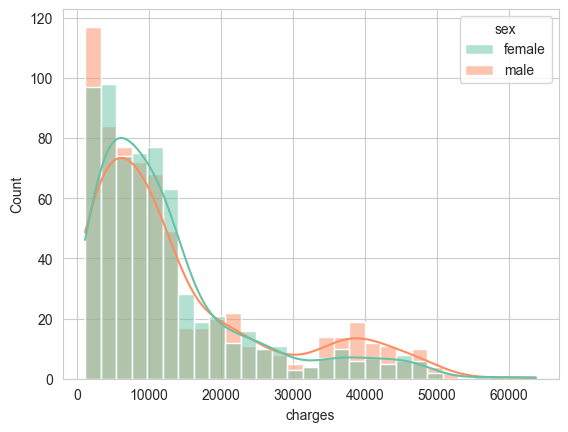

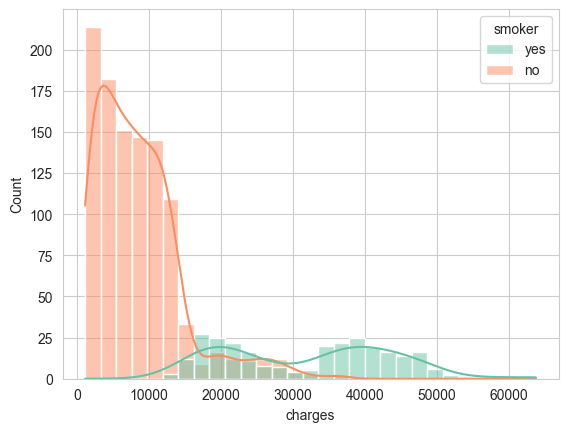

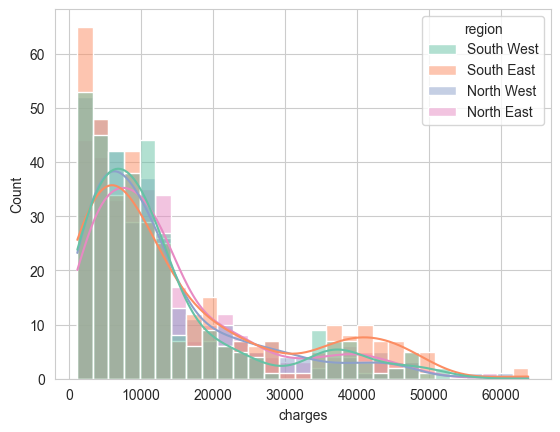

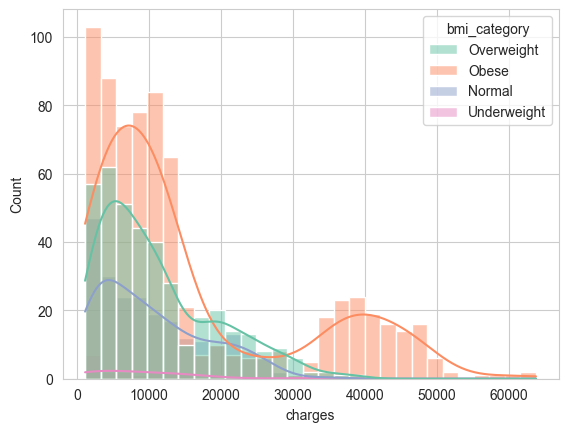

In [11]:
# create histogram of charges for categorical variables
for col in df_cat:
    sns.histplot(data=df, x='charges', hue=col , kde=True, palette='Set2')
    plt.show()
    print("\n\n")

Continuous variables by charge

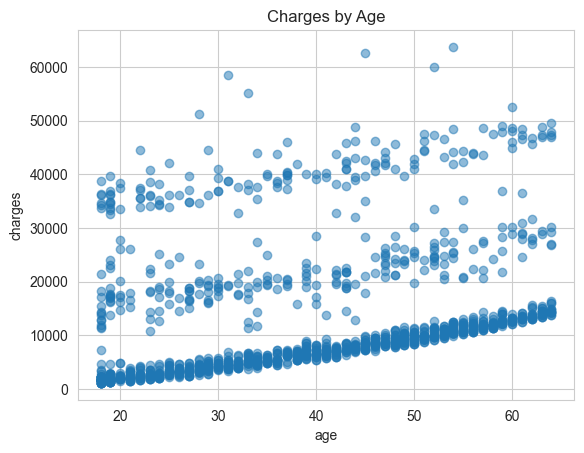

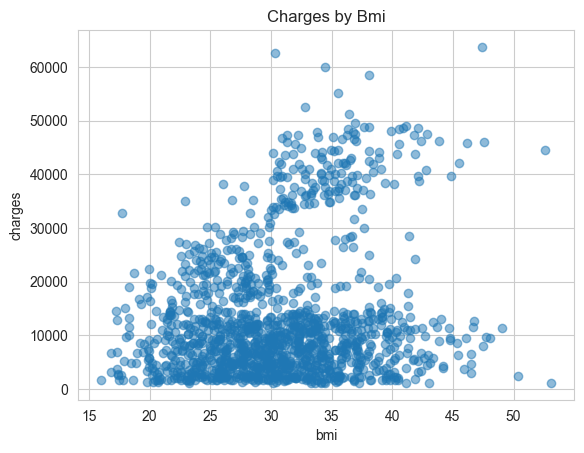

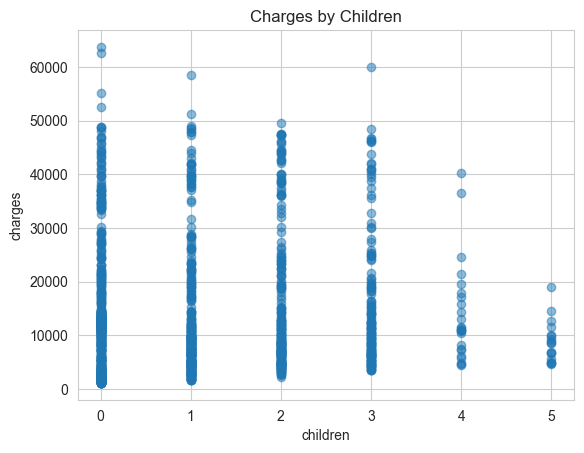

In [12]:
# create scatter plots to show how charges change for numerical columns
for col in df_num:
    # check if column is not charges and create plot
    if col != 'charges':
        plt.scatter(df_num[col], df_num['charges'], alpha=0.5)
        plt.title(f"Charges by {col.capitalize()}")
        plt.xlabel(col)
        plt.ylabel('charges')
        plt.show()
        print("\n\n")

---

## Hypothesis Testing

* H1: Smokers will have higher insurance charges than non-smokers
* H2: Charges will be positively correlated with BMI
* H3: Charges will be positively correlated with age
* H4: Children effect
* H5: Region effect
* H6: Gender effect

Helper functions for showing effect sizes:

In [13]:
# --------------------------------------------
# Effect size helpers (adapted for non-parametric context)
# --------------------------------------------

# For Mann-Whitney U tests, use rank-biserial correlation as an effect size
def rank_biserial(x, y):
    u, _ = stats.mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    rbc = 1 - (2 * u) / (n1 * n2)
    return rbc

def interpret_rbc(r):
    if abs(r) < 0.1:
        return "very small"
    elif abs(r) < 0.3:
        return "small"
    elif abs(r) < 0.5:
        return "medium"
    else:
        return "large"

# For Kruskal–Wallis (eta squared alternative)
def interpret_eta2(eta2):
    if eta2 < 0.01:
        return "very small"
    elif eta2 < 0.06:
        return "small"
    elif eta2 < 0.14:
        return "medium"
    else:
        return "large"


### Hypothesis One

Visualisation to show average charges by smoker status

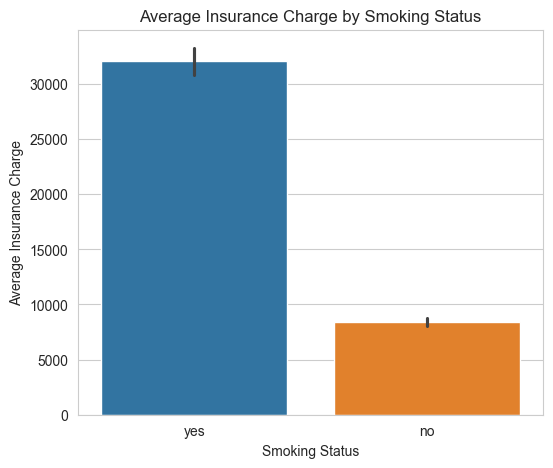

In [14]:
# create barplot to show difference between charges based on smoker status
plt.figure(figsize=(6,5))
sns.barplot(x='smoker', y='charges', data=df, estimator='mean', hue='smoker')
plt.title("Average Insurance Charge by Smoking Status")
plt.xlabel("Smoking Status")
plt.ylabel("Average Insurance Charge")
plt.show()

Statistical test of insurance charges for Smokers vs Non-Smokers (Mann–Whitney U)

In [15]:
# create lists of charges for smokers and non-smokers to use in analysis
smokers = df[df['smoker'] == 'yes']['charges']
nonsmokers = df[df['smoker'] == 'no']['charges']

#run Mann-Whitney U test for smokers vs non-smokers
u_stat, p_val = stats.mannwhitneyu(smokers, nonsmokers, alternative='two-sided')
rbc = rank_biserial(smokers, nonsmokers)
strength = interpret_rbc(rbc)
direction = "Smokers higher" if smokers.median() > nonsmokers.median() else "Non-smokers higher"

interpretation = (
    f"{'Significant difference' if p_val < 0.05 else 'No significant difference'} "
    f"(p = {p_val:.4f}). Rank-biserial correlation r = {rbc:.2f}, indicating a {strength} effect. "
    f"Median charges are {direction}."
)
print(["Smoker status", "Mann–Whitney U test", f"r = {rbc:.2f}", f"{p_val:.4f}", direction, interpretation])

['Smoker status', 'Mann–Whitney U test', 'r = -0.95', '0.0000', 'Smokers higher', 'Significant difference (p = 0.0000). Rank-biserial correlation r = -0.95, indicating a large effect. Median charges are Smokers higher.']


There is a significant difference for charges based on smoking status (p<0.05), with smokers having higher charges


### Hypothesis Two

Visualisation to show average charges by BMI category

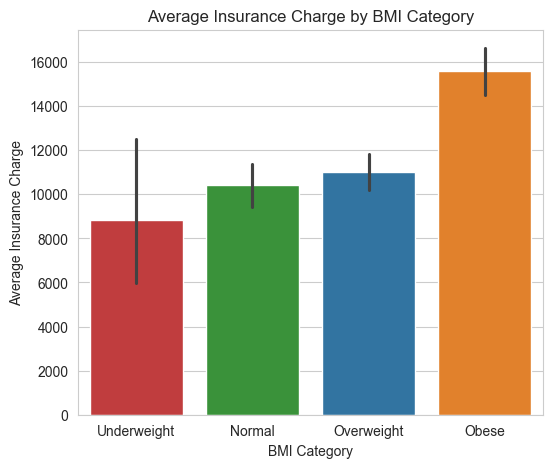

In [16]:
# create order list for BMI categories
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']

# create barplot to show difference between charges based on BMI category
plt.figure(figsize=(6,5))
sns.barplot(x='bmi_category', y='charges', data=df, estimator='mean', hue='bmi_category', order=bmi_order)
plt.title("Average Insurance Charge by BMI Category")
plt.xlabel("BMI Category")
plt.ylabel("Average Insurance Charge")
plt.show()

Statistical test of BMI correlation with insurance charges (Spearman correlation)

In [17]:
# run spearman correlation for BMI and charges

rho, p_val = stats.spearmanr(df['bmi'], df['charges'])
direction = "Positive correlation" if rho > 0 else "Negative correlation"
strength = "weak" if abs(rho) < 0.3 else "moderate" if abs(rho) < 0.6 else "strong"

interpretation = (
    f"{'Significant' if p_val < 0.05 else 'Not significant'} correlation (p = {p_val:.4f}). "
    f"Spearman's rho = {rho:.2f}, a {strength} {direction}. "
    f"This suggests that as BMI increases, charges tend to {'increase' if rho > 0 else 'decrease'}."
)
print(["BMI", "Spearman correlation", f"rho = {rho:.2f}", f"{p_val:.4f}", direction, interpretation])

['BMI', 'Spearman correlation', 'rho = 0.12', '0.0000', 'Positive correlation', "Significant correlation (p = 0.0000). Spearman's rho = 0.12, a weak Positive correlation. This suggests that as BMI increases, charges tend to increase."]


There is a significant positive correlation between charges and BMI (p<0.05), so higher BMI is likely to be linked to higher insurance costs


### Hypothesis Three

Visualisation of insurance charges by age

C:\Users\Emily\AppData\Local\Temp\ipykernel_21492\2533942892.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_charges = df_age.groupby('age_group')['charges'].mean().reset_index()


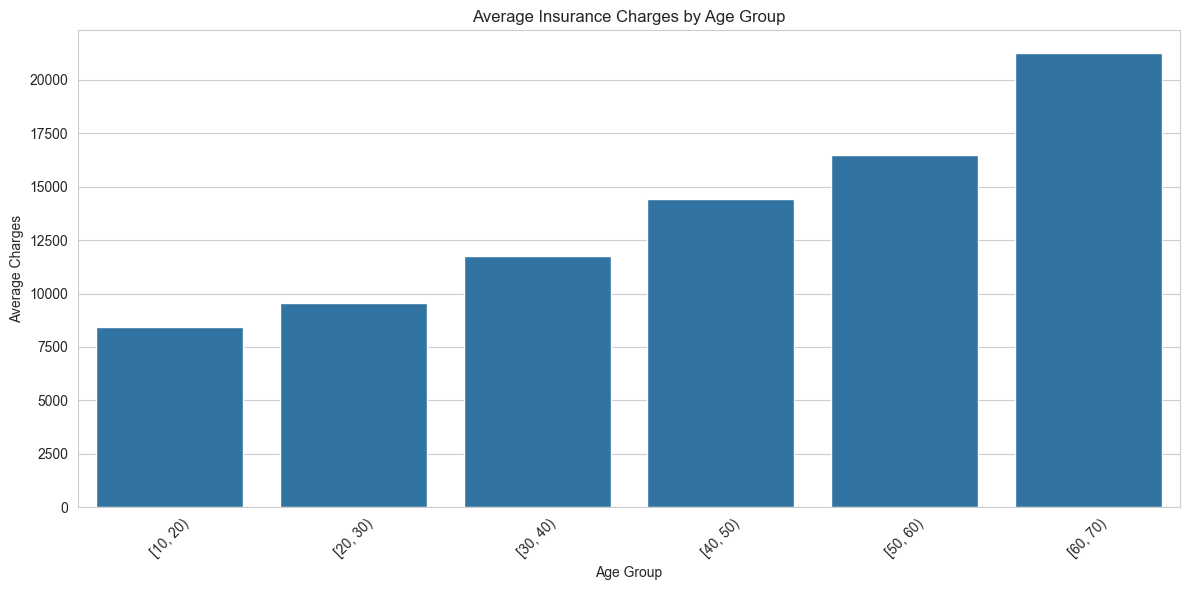

In [18]:
# create dataframe with age group column
df_age = df[['age','charges']].copy()

# create a column with bins for ages
df_age['age_group'] = pd.cut(df_age['age'], bins=[10,20,30,40,50,60,70], right=False)

# get average charges by age
age_charges = df_age.groupby('age_group')['charges'].mean().reset_index()

# create plot
plt.figure(figsize=(12,6))
sns.barplot(x='age_group', y='charges', data=age_charges)
plt.title('Average Insurance Charges by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Charges')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Statistical test of age correlation with charges (Spearman correlation)

In [19]:
# run spearman correlation for Age and charges

rho, p_val = stats.spearmanr(df['age'], df['charges'])
direction = "Positive correlation" if rho > 0 else "Negative correlation"
strength = "weak" if abs(rho) < 0.3 else "moderate" if abs(rho) < 0.6 else "strong"

interpretation = (
    f"{'Significant' if p_val < 0.05 else 'Not significant'} correlation (p = {p_val:.4f}). "
    f"Spearman's rho = {rho:.2f}, a {strength} {direction}. "
    f"This suggests that as Age increases, charges tend to {'increase' if rho > 0 else 'decrease'}."
)
print(["Age", "Spearman correlation", f"rho = {rho:.2f}", f"{p_val:.4f}", direction, interpretation])

['Age', 'Spearman correlation', 'rho = 0.53', '0.0000', 'Positive correlation', "Significant correlation (p = 0.0000). Spearman's rho = 0.53, a moderate Positive correlation. This suggests that as Age increases, charges tend to increase."]


There is a significant positive correlation between charges and Age (p<0.05), as Age increases charges tend to be higher

### Hypothesis Four

Visualisation of the effect of number of children on insurance charges

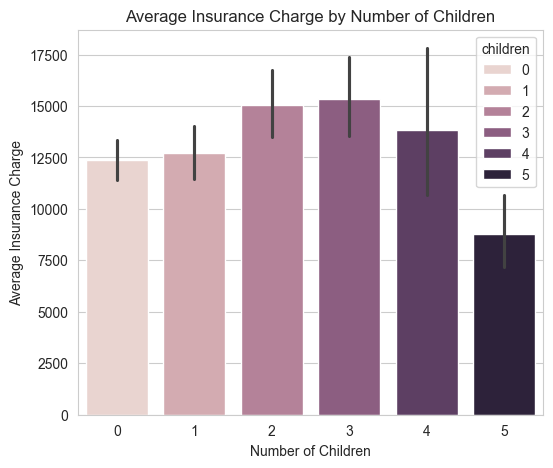

In [20]:
# create barplot to show difference between charges based on number of children
plt.figure(figsize=(6,5))
sns.barplot(x='children', y='charges', data=df, estimator='mean', hue='children')
plt.title("Average Insurance Charge by Number of Children")
plt.xlabel("Number of Children")
plt.ylabel("Average Insurance Charge")
plt.show()

Statistical test for the effect of number of children on insurance charges (Kruskal–Wallis test)

In [21]:
# prepare column data for analysis
groups_children = [df[df.children == c]['charges'] for c in sorted(df.children.unique())]

# run Kruskal-Wallis test
h_stat, p_val = stats.kruskal(*groups_children)
# Effect size for Kruskal–Wallis (eta squared approximation)
n = len(df)
eta2 = (h_stat - len(groups_children) + 1) / (n - len(groups_children))
strength = interpret_eta2(eta2)
direction = df.groupby('children')['charges'].median().idxmax()

interpretation = (
    f"{'Significant' if p_val < 0.05 else 'Not significant'} difference across child groups (p = {p_val:.4f}). "
    f"Effect size η² = {eta2:.2f}, which is {strength}. "
    f"The highest median charges occur among families with {direction} children."
)
print(["Children", "Kruskal–Wallis test", f"η² = {eta2:.2f}", f"{p_val:.4f}", f"Highest in {direction} children", interpretation])

['Children', 'Kruskal–Wallis test', 'η² = 0.02', '0.0000', 'Highest in 4 children', 'Significant difference across child groups (p = 0.0000). Effect size η² = 0.02, which is small. The highest median charges occur among families with 4 children.']


There is a significant difference between charges based on number of children (p<0.05). The highest median charges occur among families with 4 children.

### Hypothesis Five

Visualisation for average insurance charges by region

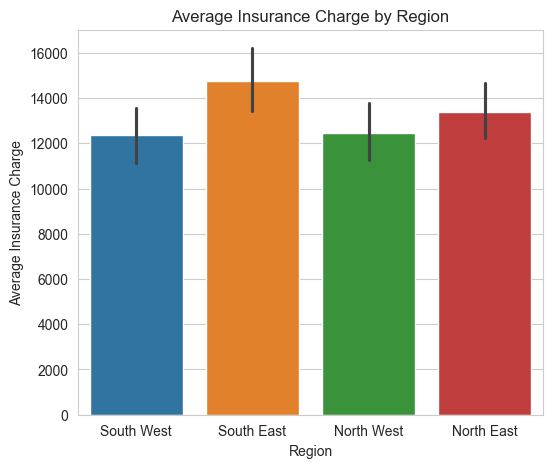

In [ ]:


# create barplot to show difference between charges based on region
plt.figure(figsize=(6,5))
sns.barplot(x='str_region', y='charges', data=df_reg, estimator='mean', hue='str_region')
plt.title("Average Insurance Charge by Region")
plt.xlabel("Region")
plt.ylabel("Average Insurance Charge")
plt.show()

Statistical test for the effect of region on insurance charges (Kruskal–Wallis test)

In [22]:
#create

# prepare column data for analysis
groups = [df[df.region == r]['charges'] for r in df.region.unique()]

# run Kruskal-Wallis test
h_stat, p_val = stats.kruskal(*groups)
# Effect size for Kruskal–Wallis (eta squared approximation)
n = len(df)
eta2 = (h_stat - len(groups) + 1) / (n - len(groups))
strength = interpret_eta2(eta2)
direction = df.groupby('region')['charges'].median().idxmax()

interpretation = (
    f"{'Significant' if p_val < 0.05 else 'Not significant'} difference across regions (p = {p_val:.4f}). "
    f"Effect size η² = {eta2:.2f} ({strength}). The region with highest median charges is {direction}."
)
print(["Region", "Kruskal–Wallis test", f"η² = {eta2:.2f}", f"{p_val:.4f}", f"Highest in {direction}", interpretation])

['Region', 'Kruskal–Wallis test', 'η² = 0.00', '0.2016', 'Highest in North East', 'Not significant difference across regions (p = 0.2016). Effect size η² = 0.00 (very small). The region with highest median charges is North East.']


There is no significant difference across regions for insurance charges

### Hypothesis Six

Barplot showing average insurance charges by sex

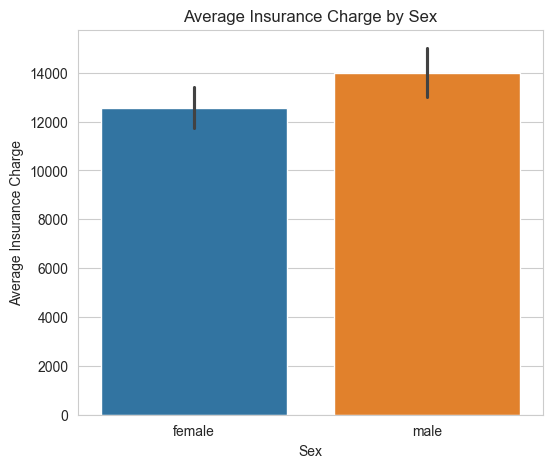

In [112]:
# create barplot to show difference between charges based on sex
plt.figure(figsize=(6,5))
sns.barplot(x='sex', y='charges', data=df, estimator='mean', hue='sex')
plt.title("Average Insurance Charge by Sex")
plt.xlabel("Sex")
plt.ylabel("Average Insurance Charge")
plt.show()

Statistical test for the effect of sex on insurance charges (Mann–Whitney U test)

In [113]:
# create lists of charges by sex to use in analysis
male = df[df.sex == 'male']['charges']
female = df[df.sex == 'female']['charges']

#run Mann-Whitney U test for male vs female charges
u_stat, p_val = stats.mannwhitneyu(male, female, alternative='two-sided')
rbc = rank_biserial(male, female)
strength = interpret_rbc(rbc)
direction = "Male higher" if male.median() > female.median() else "Female higher"

interpretation = (
    f"{'Significant difference' if p_val < 0.05 else 'No significant difference'} "
    f"(p = {p_val:.4f}). Rank-biserial r = {rbc:.2f} ({strength} effect). "
    f"Median charges are {direction}."
)
print(["Gender", "Mann–Whitney U test", f"r = {rbc:.2f}", f"{p_val:.4f}", direction, interpretation])

['Gender', 'Mann–Whitney U test', 'r = -0.01', '0.6945', 'Female higher', 'No significant difference (p = 0.6945). Rank-biserial r = -0.01 (very small effect). Median charges are Female higher.']


There is no significant difference between charges by sex

---

## Main Findings and Next Steps

* H1: There is a significant difference for charges based on smoking status (p<0.05), with smokers having higher charges
* H2: There is a significant positive correlation between charges and BMI (p<0.05), so higher BMI is likely to be linked to higher insurance costs
* H3: There is a significant positive correlation between charges and Age (p<0.05), as Age increases charges tend to be higher
* H4: There is a significant difference between charges based on number of children (p<0.05). The highest median charges occur among families with 4 children.
* H5: There is no significant difference across regions for insurance charges
* H6: There is no significant difference between charges by sex

This notebook explores basic relationships between demographics and insurance charges. Interactions between demographics and insurance charges will be explored in notebook 3.